# 3D Multi-organ Segmentation with UNETR  (BTCV Challenge)

Prepared by: **Ali Hatamizadeh** and **Yucheng Tang**.

This tutorial demonstrates how to construct a training workflow of UNETR on multi-organ segmentation task using the BTCV challenge dataset.
![image](https://lh3.googleusercontent.com/pw/AM-JKLU2eTW17rYtCmiZP3WWC-U1HCPOHwLe6pxOfJXwv2W-00aHfsNy7jeGV1dwUq0PXFOtkqasQ2Vyhcu6xkKsPzy3wx7O6yGOTJ7ZzA01S6LSh8szbjNLfpbuGgMe6ClpiS61KGvqu71xXFnNcyvJNFjN=w1448-h496-no?authuser=0)

And it contains the following features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNETR model, Dice loss function, Mean Dice metric for multi-oorgan segmentation task.

The dataset comes from https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

Under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm. 

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kideny 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from: 


1. [UNETR: Transformers for 3D Medical Image Segmentation](https://arxiv.org/abs/2103.10504)

2. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

3. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](https://lh3.googleusercontent.com/pw/AM-JKLX0svvlMdcrchGAgiWWNkg40lgXYjSHsAAuRc5Frakmz2pWzSzf87JQCRgYpqFR0qAjJWPzMQLc_mmvzNjfF9QWl_1OHZ8j4c9qrbR6zQaDJWaCLArRFh0uPvk97qAa11HtYbD6HpJ-wwTCUsaPcYvM=w1724-h522-no?authuser=0)



The image patches show anatomies of a subject, including: 
1. large organs: spleen, liver, stomach. 
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas. 
3. Vascular tissues: aorta, IVC, P&S Veins. 
4. Glands: left and right adrenal gland

## Setup environment

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.metrics import compute_meandice
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    AddChanneld,
    Compose,
    MapTransform,
    CropForegroundd,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    load_decathlon_properties,
    partition_dataset,
    select_cross_validation_folds,
    SmartCacheDataset,
    Dataset,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.6.dev2127
Numpy version: 1.21.0
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 889f33577be13b590211663995d2285aafc8fd74

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.1.1
scikit-image version: 0.14.2
Pillow version: 5.4.1
Tensorboard version: 2.2.0
gdown version: 3.13.0
TorchVision version: 0.7.0
ITK version: 5.1.2
tqdm version: 4.59.0
lmdb version: 1.2.1
psutil version: 5.6.1
pandas version: 0.24.2
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp75xwre21


## Setup transforms for training and validation

In [4]:
train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            ScaleIntensityRanged(
                keys=["image"], a_min=-175, a_max=250,
                b_min=0.0, b_max=1.0, clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(96, 96, 96),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
            RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
            ),
            RandFlipd(
                keys=["image", "label"],
                spatial_axis=[1],
                prob=0.10,
            ),
            RandFlipd(
                keys=["image", "label"],
                spatial_axis=[2],
                prob=0.10,
            ),
            RandRotate90d(
                keys=["image", "label"],
                prob=0.10,
                max_k = 3,
            ),
            RandShiftIntensityd(
                keys=["image"],
                offsets=0.10,
                prob=0.50,
            ),
            ToTensord(keys=["image", "label"]),
        ]
    )
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

 ## Download dataset and format in the folder.
    1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json
    Example of JSON file:
     {
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        "imagesTs/img0061.nii.gz",
        "imagesTs/img0062.nii.gz",
        "imagesTs/img0063.nii.gz",
        "imagesTs/img0064.nii.gz",
        "imagesTs/img0065.nii.gz",
        "imagesTs/img0066.nii.gz",
        "imagesTs/img0067.nii.gz",
        "imagesTs/img0068.nii.gz",
        "imagesTs/img0069.nii.gz",
        "imagesTs/img0070.nii.gz",
        "imagesTs/img0071.nii.gz",
        "imagesTs/img0072.nii.gz",
        "imagesTs/img0073.nii.gz",
        "imagesTs/img0074.nii.gz",
        "imagesTs/img0075.nii.gz",
        "imagesTs/img0076.nii.gz",
        "imagesTs/img0077.nii.gz",
        "imagesTs/img0078.nii.gz",
        "imagesTs/img0079.nii.gz",
        "imagesTs/img0080.nii.gz"
    ],
    "training": [
        {
            "image": "imagesTr/img0001.nii.gz",
            "label": "labelsTr/label0001.nii.gz"
        },
        {
            "image": "imagesTr/img0002.nii.gz",
            "label": "labelsTr/label0002.nii.gz"
        },
        {
            "image": "imagesTr/img0003.nii.gz",
            "label": "labelsTr/label0003.nii.gz"
        },
        {
            "image": "imagesTr/img0004.nii.gz",
            "label": "labelsTr/label0004.nii.gz"
        },
        {
            "image": "imagesTr/img0005.nii.gz",
            "label": "labelsTr/label0005.nii.gz"
        },
        {
            "image": "imagesTr/img0006.nii.gz",
            "label": "labelsTr/label0006.nii.gz"
        },
        {
            "image": "imagesTr/img0007.nii.gz",
            "label": "labelsTr/label0007.nii.gz"
        },
        {
            "image": "imagesTr/img0008.nii.gz",
            "label": "labelsTr/label0008.nii.gz"
        },
        {
            "image": "imagesTr/img0009.nii.gz",
            "label": "labelsTr/label0009.nii.gz"
        },
        {
            "image": "imagesTr/img0010.nii.gz",
            "label": "labelsTr/label0010.nii.gz"
        },
        {
            "image": "imagesTr/img0021.nii.gz",
            "label": "labelsTr/label0021.nii.gz"
        },
        {
            "image": "imagesTr/img0022.nii.gz",
            "label": "labelsTr/label0022.nii.gz"
        },
        {
            "image": "imagesTr/img0023.nii.gz",
            "label": "labelsTr/label0023.nii.gz"
        },
        {
            "image": "imagesTr/img0024.nii.gz",
            "label": "labelsTr/label0024.nii.gz"
        },
        {
            "image": "imagesTr/img0025.nii.gz",
            "label": "labelsTr/label0025.nii.gz"
        },
        {
            "image": "imagesTr/img0026.nii.gz",
            "label": "labelsTr/label0026.nii.gz"
        },
        {
            "image": "imagesTr/img0027.nii.gz",
            "label": "labelsTr/label0027.nii.gz"
        },
        {
            "image": "imagesTr/img0028.nii.gz",
            "label": "labelsTr/label0028.nii.gz"
        },
        {
            "image": "imagesTr/img0029.nii.gz",
            "label": "labelsTr/label0029.nii.gz"
        },
        {
            "image": "imagesTr/img0030.nii.gz",
            "label": "labelsTr/label0030.nii.gz"
        },
        {
            "image": "imagesTr/img0031.nii.gz",
            "label": "labelsTr/label0031.nii.gz"
        },
        {
            "image": "imagesTr/img0032.nii.gz",
            "label": "labelsTr/label0032.nii.gz"
        },
        {
            "image": "imagesTr/img0033.nii.gz",
            "label": "labelsTr/label0033.nii.gz"
        },
        {
            "image": "imagesTr/img0034.nii.gz",
            "label": "labelsTr/label0034.nii.gz"
        }
    ],
    "validation": [
        {
            "image": "imagesTr/img0035.nii.gz",
            "label": "labelsTr/label0035.nii.gz"
        },
        {
            "image": "imagesTr/img0036.nii.gz",
            "label": "labelsTr/label0036.nii.gz"
        },
        {
            "image": "imagesTr/img0037.nii.gz",
            "label": "labelsTr/label0037.nii.gz"
        },
        {
            "image": "imagesTr/img0038.nii.gz",
            "label": "labelsTr/label0038.nii.gz"
        },
        {
            "image": "imagesTr/img0039.nii.gz",
            "label": "labelsTr/label0039.nii.gz"
        },
        {
            "image": "imagesTr/img0040.nii.gz",
            "label": "labelsTr/label0040.nii.gz"
        }
    ]
}
    

In [6]:
data_dir ='/dataset/'
split_JSON = 'dataset_0.json'
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(data=datalist, transform=train_transforms, cache_num=24, cache_rate=1.0, num_workers=8)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


## Check data shape and visualize

image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


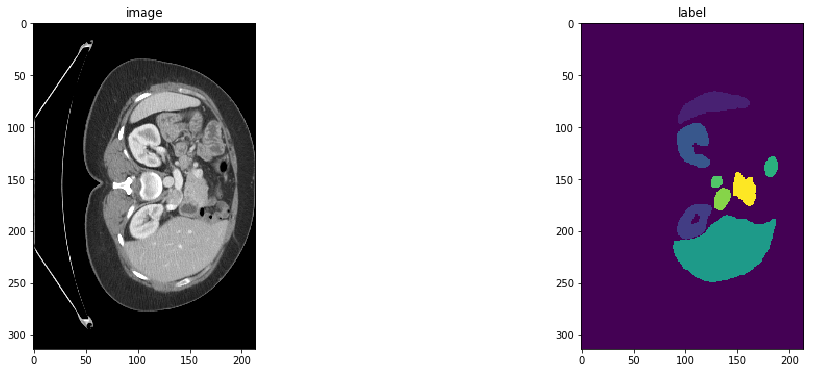

In [7]:
slice_map = {'img0035.nii.gz':170,'img0036.nii.gz':230,'img0037.nii.gz':204,'img0038.nii.gz':204,
             'img0039.nii.gz':204,'img0040.nii.gz':180}
case_num = 0
img_name = os.path.split(val_ds[case_num]['image_meta_dict']['filename_or_obj'])[1]
img = val_ds[case_num]['image']
label = val_ds[case_num]['label'] 
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title(f"image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed='perceptron',
    norm_name='instance',
    res_block=True,
    dropout_rate=0.0).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description("Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice))
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step!=0) or global_step==max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print('Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}'.format(dice_val_best, dice_val))
            else:
                print('Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}'.format(dice_val_best, dice_val))
                
            
        global_step += 1
    
    
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=True, n_classes=14)
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

In [10]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}")

train completed, best_metric: 0.8064 at iteration: 21500


### Plot the loss and metric

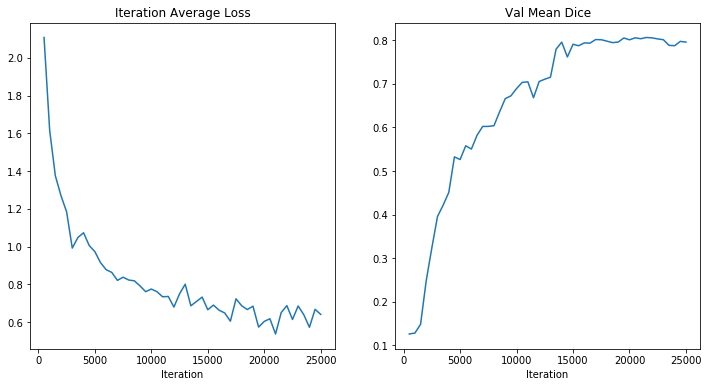

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

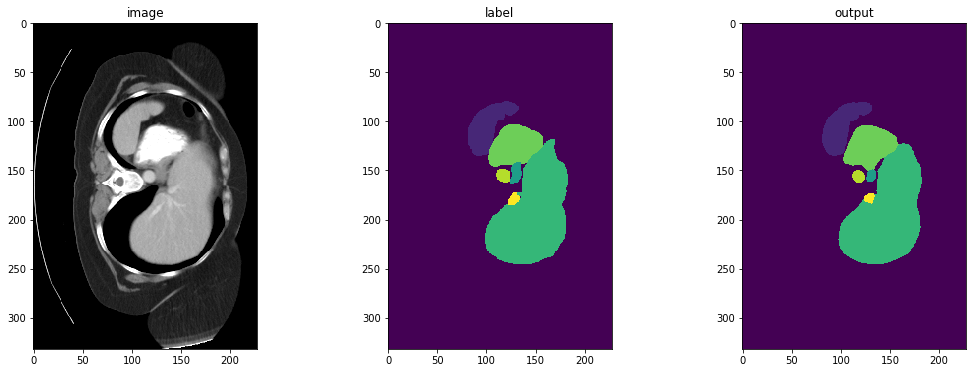

In [12]:
case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]['image_meta_dict']['filename_or_obj'])[1]
    img = val_ds[case_num]['image']
    label = val_ds[case_num]['label']
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label,1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title(f"output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [12]:
if directory is None:
    shutil.rmtree(root_dir)